In [1]:
import sys
import math
import random
import warnings
import sklearn
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as im
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import *
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.losses import binary_crossentropy
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from pylab import rcParams
import tensorflow as tf
import os

Using TensorFlow backend.
D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\tensorflo

In [2]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = 'G:/OurData/slice/'
TRAIN_MASK = 'G:/OurData/mask/'
TEST_PATH = 'G:/OurData/test_slice/'
TEST_MASK = 'G:/OurData/test_mask/'

In [3]:
X_train = []
Y_train = []
X_test = []
Y_test = []
sys.stdout.flush()
file1 = os.listdir(TRAIN_PATH)
file1.sort(key=lambda x:int(x[7:-5]))
file2 = os.listdir(TRAIN_MASK)
file2.sort(key=lambda x:int(x[11:-5]))
file3 = os.listdir(TEST_PATH)
file3.sort(key=lambda x:int(x[7:-5]))
file4 = os.listdir(TEST_MASK)
file4.sort(key=lambda x:int(x[11:-5]))
#print(file1)
#print(file2)
for i in tqdm(file1):
    img = imread(TRAIN_PATH + i)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1),mode='constant', preserve_range=True)
    X_train.append(img)
for n in tqdm(file2):
    mask = imread(TRAIN_MASK + n)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1),mode='constant', preserve_range=True)
    Y_train.append(mask)
for i in tqdm(file3):
    imgt = imread(TEST_PATH + i)
    imgt = resize(imgt, (IMG_HEIGHT, IMG_WIDTH, 1),mode='constant', preserve_range=True)
    X_test.append(imgt)
for n in tqdm(file4):
    maskt = imread(TEST_MASK + n)
    maskt = resize(maskt, (IMG_HEIGHT, IMG_WIDTH, 1),mode='constant', preserve_range=True)
    Y_test.append(maskt)

100%|█████████████████████████████████████████████████████████████████████████████| 1375/1375 [00:13<00:00, 100.27it/s]


In [4]:
X_train = np.array(X_train,dtype=np.uint8)
Y_train = np.array(Y_train,dtype=np.uint8)
X_test = np.array(X_test,dtype=np.uint8)
Y_test = np.array(Y_test,dtype=np.uint8)

In [5]:
X_train,Y_train = sklearn.utils.shuffle(X_train,Y_train)

9367


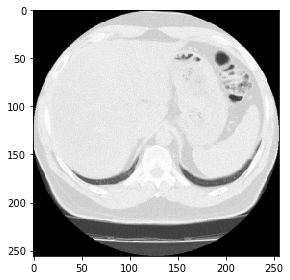

D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


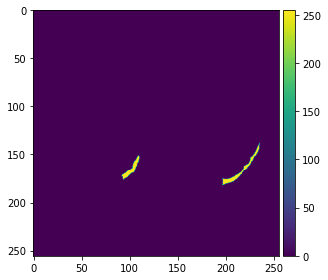

903


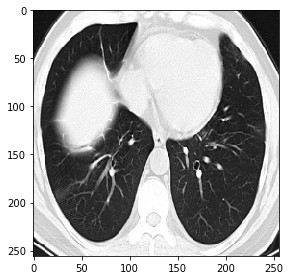

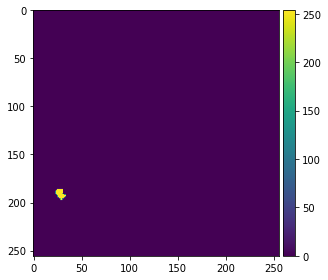

In [6]:
i = random.randint(0, len(X_train))
print(i)
imshow(X_train[i])
plt.show()
imshow(Y_train[i])
plt.show()
ix = random.randint(0, len(X_test))
print(ix)
imshow(X_test[ix])
plt.show()
imshow(Y_test[ix])
plt.show()

In [7]:
X_train = X_train/255
Y_train = Y_train/255
X_test = X_test/255

In [8]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.5*binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    Ncl = y_pred.shape[-1]
    w = K.zeros(shape=(Ncl,))
    w = K.sum(y_true, axis=(0,1,2))
    w = 1/(w**2+0.000001)
    # Compute gen dice coef:
    numerator = y_true*y_pred
    numerator = w*K.sum(numerator,(0,1,2,3))
    numerator = K.sum(numerator)
    denominator = y_true+y_pred
    denominator = w*K.sum(denominator,(0,1,2,3))
    denominator = K.sum(denominator)
    gen_dice_coef = 2*numerator/denominator
    return gen_dice_coef

def generalized_dice_loss(y_true, y_pred):
    return 1 - generalized_dice_coeff(y_true, y_pred)

In [9]:
def squeeze_excitation(input, num_channel, reduction_ratio):
    """
    实现squeeze_Excitation  
    :param input: 输入张量
    :param num_channel: 对应全连接层的神经元数目，由于最后是相乘操作
                        所以这个数值是input的通道数目
    :param reduction_ratio: 这是对全连接层进行缩放的参数，相当于一个缩放比
    :return: 与全局信息相乘的输入
              即 input X excitation
    """
    pool = GlobalMaxPooling2D()(input)
    #print(pool.shape)
    squeeze = Dense(int(num_channel // reduction_ratio), activation='relu')(pool)
    excitation = Dense(num_channel, activation='sigmoid')(squeeze)
    #print(excitation.shape)
    scale = Multiply()([input, excitation])

    return scale

def ASPP(inputs):
    conv1 = Conv2D(128, 1, activation = 'relu', padding = 'valid', dilation_rate=(1,1),kernel_initializer = 'he_normal')(inputs)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', dilation_rate=(2,2),kernel_initializer = 'he_normal')(inputs)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', dilation_rate=(4,4),kernel_initializer = 'he_normal')(inputs)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', dilation_rate=(6,6),kernel_initializer = 'he_normal')(inputs)
    conv = concatenate([conv1,conv2,conv3,conv4], axis = 3)
    conv = Conv2D(512, 1, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv)
    conv = BatchNormalization()(conv)
    x = LeakyReLU()(conv)
    return x

def conv_block(input_tensor, num_of_channels, kernel_size, dropout_rate):
    inputs =  Conv2D(num_of_channels, (1, 1), activation="elu", kernel_initializer = 'he_normal', padding='same' )(input_tensor)
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation="elu", kernel_initializer = 'he_normal', padding='same' )(inputs)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation="elu", kernel_initializer = 'he_normal', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = squeeze_excitation(x,num_of_channels,6)
    x = add([x,inputs])
    return x

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
c1 = conv_block(inputs,32,3,0)
p1 = MaxPooling2D((2, 2)) (c1)
c2 = conv_block(p1,64,3,0)
p2 = MaxPooling2D((2, 2)) (c2)

up1_2 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c2)
conv1_2 = concatenate([up1_2,c1],axis=3)
conv1_2 = conv_block(conv1_2, 32, 3, 0)

c3 = conv_block(p2, 128, 3, 0.2)
p3 = MaxPooling2D((2, 2)) (c3)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
conv2_2 = concatenate([up2_2, c2], axis=3)
conv2_2 = conv_block(conv2_2, 64, 3, 0)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, conv1_2], axis=3)
conv1_3 = conv_block(conv1_3, 32, 3, 0)

c4 = conv_block(p3, 256, 3, 0.3)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
conv3_2 = concatenate([up3_2, c3], axis=3)
conv3_2 = conv_block(conv3_2, 128, 3, 0.2)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], axis=3)
conv2_3 = conv_block(conv2_3, 64, 3, 0)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, conv1_2, conv1_3], axis=3)
conv1_4 = conv_block(conv1_4, 32, 3, 0)

c5 = conv_block(p4,512, 3, 0.4)
c5 = ASPP(c5)

up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
conv4_2 = concatenate([up4_2, c4],  axis=3)
conv4_2 = conv_block(conv4_2, 256, 3, 0.3)

up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, c3, conv3_2],  axis=3)
conv3_3 = conv_block(conv3_3, 128, 3, 0.2)

up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], axis=3)
conv2_4 = conv_block(conv2_4, 64, 3, 0)

up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, conv1_2, conv1_3, conv1_4],  axis=3)
conv1_5 = conv_block(conv1_5, 32, 3, 0)

nestnet_output = Conv2D(1, (1, 1), activation ='sigmoid',
                        kernel_initializer= 'he_normal', padding='same')(conv1_5)
    
model = Model(inputs=[inputs], outputs=[nestnet_output])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 64          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 32) 0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [27]:
checkpointer = ModelCheckpoint('rzqunet++20210324.h5', verbose=1, save_best_only=True)
Adam = optimizers.Adam(lr=1e-5)
model.compile(optimizer=Adam, loss=generalized_dice_loss, metrics=[dice_coeff])
earlystopper = EarlyStopping(patience=10, verbose=1)
results = model.fit(X_train, Y_train, batch_size=2, epochs=200,
                    validation_split=0.2,
                    callbacks = [earlystopper,checkpointer])

Train on 8000 samples, validate on 2000 samples
Epoch 1/200
8000/8000 [==============================] - 608s 76ms/step - loss: 0.0793 - dice_coeff: 0.9207 - val_loss: 0.1133 - val_dice_coeff: 0.8868

Epoch 00001: val_loss improved from inf to 0.11329, saving model to rzqunet++20210324.h5
Epoch 2/200
8000/8000 [==============================] - 599s 75ms/step - loss: 0.0798 - dice_coeff: 0.9202 - val_loss: 0.1135 - val_dice_coeff: 0.8865

Epoch 00002: val_loss did not improve from 0.11329
Epoch 3/200
8000/8000 [==============================] - 599s 75ms/step - loss: 0.0792 - dice_coeff: 0.9208 - val_loss: 0.1131 - val_dice_coeff: 0.8869

Epoch 00003: val_loss improved from 0.11329 to 0.11312, saving model to rzqunet++20210324.h5
Epoch 4/200
8000/8000 [==============================] - 598s 75ms/step - loss: 0.0787 - dice_coeff: 0.9213 - val_loss: 0.1133 - val_dice_coeff: 0.8867

Epoch 00004: val_loss did not improve from 0.11312
Epoch 5/200
8000/8000 [==============================] -

KeyboardInterrupt: 

# plt.plot(results.history['dice_coeff'])
plt.plot(results.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.ylabel('Dice coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('0225-2dice')
plt.show()
# summarize history for loss
plt.ylim(0, 0.6)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Dice Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('0225-2loss')
plt.show()

In [ ]:
model = load_model('unet++20210306.h5', custom_objects={'generalized_dice_loss': generalized_dice_loss,'dice_coeff':dice_coeff})

In [ ]:
#preds_train = model.predict(X_train[:int(X_train.shape[0]*0.85)],batch_size=2, verbose=0)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.85):],batch_size=2,verbose=0)

In [28]:
preds_test = model.predict(X_test,batch_size=4,verbose=0)

In [ ]:
print(preds_test[1].shape)

161


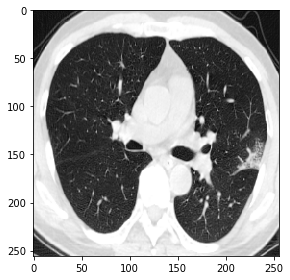

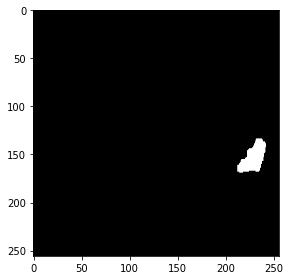

D:\Anaconda\envs\tensorflow-gpu\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


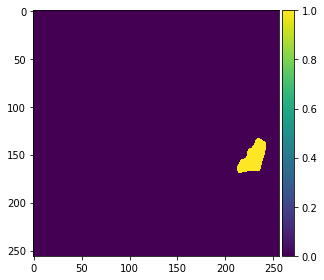

In [29]:
n = random.randint(0, len(preds_test))
print(n)
#n=50
imshow(X_test[n])
plt.show()
imshow(Y_test[n])
plt.show()
imshow(preds_test[n])
plt.show()

In [30]:
for i in range(0,1375,1):
    cv2.imwrite('G:/TestResults/rzunet++/rzmask_'+str(i)+'.png',preds_test[i]*255)

In [ ]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
for i in range(0,1375,1):
    cv2.imwrite('G:/TestResults/tt/tt_'+str(i)+'.png',preds_test_t[i]*255)

In [ ]:
for i in range(1,1375):
    image = preds_test[i]
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    im.imsave('G:/TestResults/unet/test'+str(i)+'.png',image)

In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
# i = random.randint(0, len(preds_train))
# imshow(X_train[i])
# plt.show()
# imshow(Y_train[i])
# plt.show()
# imshow(preds_train[i])
# #imshow(preds_train_t[i])
# plt.show()

In [ ]:
n = random.randint(0, len(preds_val))
print(n)
imshow(X_train[int(X_train.shape[0]*0.85):][n])
plt.show()
imshow(Y_train[int(Y_train.shape[0]*0.85):][n])
plt.show()
imshow(preds_val[n])
#imshow(preds_val_t[i])
plt.show()

In [ ]:
for i in range(len(preds_test)):
    with tf.Session() as sess:
        dice = sess.run(dice_coeff(Y_test[i], preds_test[i]))
        print(dice)